# Task 4 : Data Collection in the Wild [4 marks]

## Task Description

For this exercise marks will not depend on what numbers you get but on the process you followed Utilize apps like `Physics Toolbox Suite` from your smartphone to collect your data in .csv/.txt format. Ensure at least 15 seconds of data is collected, trimming edges to obtain 10 seconds of relevant data. Also record a video of yourself while recording data. This video will be required in some future assignments. Collect 3-5 samples per activity class.

### Questions

1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? **[1 marks]**
2. Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? **[1 marks]**
3. Use the Few-Shot prompting method using UCI-HAR dataset to predict the activities that you performed. Ensure that both your examples and test query undergo similar preprocessing. How did the model perform? **[1 marks]**
4. Use the Few-Shot prompting method using the data you collected to predict the activities that you performed. Adopt proper processing methods as needed. How did the model perform? **[1 marks]**

Firsly after collecting all the data, we preprocess it. We used the gForece meter of the `Physics Toolbox Suite` app to collect the data. However there were some difficulties which we faced when preprocessing the data. The data that was collected was sampled at the highest frequency possible from our mobile. Hence the samples were also not evenly spaced. The sampling frequency kept changing between 190 Hz to 210 Hz. This made it difficult to use the data as it is. So we took a sliding window of 20 miliseconds and calculated the mean of the samples in that window. This way we were able to get evenly spaced samples at a frequency of 50 Hz.

All the preprocessing was done in `./Datasets/task4_datacollection/Asst#4_process_raw.ipynb` notebook. After that we run/train the pretrained/new models on the data which we collected and analyse the results.

## Results for Task 4

| Features Type | Training Data | Testing Data | Accuracy | Precision | Recall |
|---------------|---------------|--------------|----------|-----------|--------|
| Raw accelerometer data      | UCI-HAR       | Custom       | 0.3472      | 0.4476       | 0.3472    |
| TSFEL data (all features)    | UCI-HAR       | Custom       | 0.4791      | 0.5       | 0.479    |
| TSFEL data (filtered features)      | UCI-HAR       | Custom       | 0.791      | 0.8143       | 0.716    |
| Raw accelerometer data | Custom (2 subjects)      | Custom (1 subject)      | 0.625      | 0.6388       | 0.625    |
| TSFEL data (all features)      | Custom (2 subjects)      | Custom (1 subject)     | 0.75      | 0.7407       | 0.75    |
| TSFEL data (filtered features)    | Custom (2 subjects)      | Custom (1 subject)     | 0.66      | 0.674       | 0.66    |

As we can see, when trained on the UCI-HAR dataset, the model performs better on the custom dataset when the features are filtered, with an accuracy of 0.791. 

When trained on the custom dataset, the model performs better when the features are all used, with an accuracy of 0.75.

## Custom data leave-one-out Cross validation results
We did cross validation by leaving one activity per subject out. We trained the model on the remaining activities and tested on the left out activity. We repeated this for all the activities and subjects. The results are as follows:

| Features Type | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| Raw accelerometer data | 0.5417      | 0.4638       | 0.5417    |
| TSFEL data (all features)      | 0.9306      | 0.9455       | 0.9306    |
| TSFEL data (filtered features)      | 0.8750      | 0.8772       | 0.8750    |

Here, we see that the model performs best when trained on the TSFEL data with all features, with an accuracy of 0.9306.




## Importing required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from tqdm import tqdm
from typing import Union
import re
from langchain_groq.chat_models import ChatGroq
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (classification_report, precision_score, recall_score, accuracy_score, 
                             confusion_matrix)
from MakeTask4Dataset import X, y

## Utility functions

In [181]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def get_sample_data(path, files_per_activity=-1):
    sample_data = []
    for activity_class in activity_classes:
        subpath = os.path.join(path, activity_class)
        files = os.listdir(subpath)
        num_files = len(files) if files_per_activity == -1 else files_per_activity
        for file in range(num_files):
            sample_data.append(os.path.join(subpath, files[file]))
    return sample_data

def plot_waveforms(sample_data, titles, plot_title, start):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(22, 4))
    fig.suptitle(plot_title)

    dfs = [pd.read_csv(sample).iloc[start:start+500, :] for sample in sample_data]

    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
        ax.set_title(titles[i])
        ax.set_ylim([-1, 2.2])
        ax.set_xlim([start, start+500])
        ax.plot(dfs[i]['accx'], color='r', label='accx')
        ax.plot(dfs[i]['accy'], color='g', label='accy')
        ax.plot(dfs[i]['accz'], color='b', label='accz')
        ax.legend()
        ax.grid(True)  # Add grid to the plot

    plt.show()

## Visualising the UCI and custom datasets

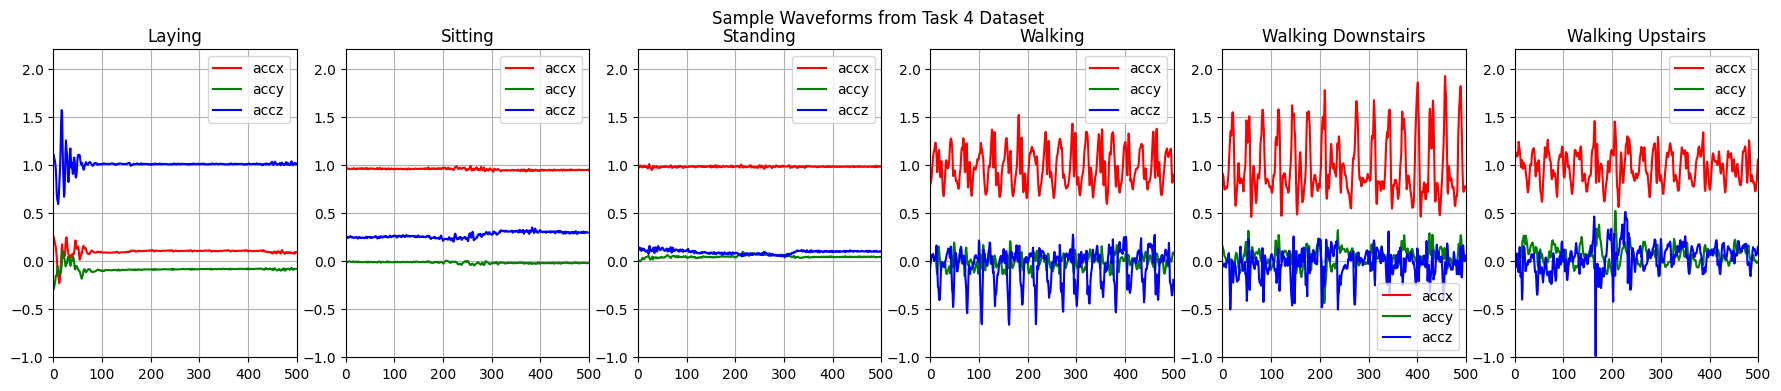

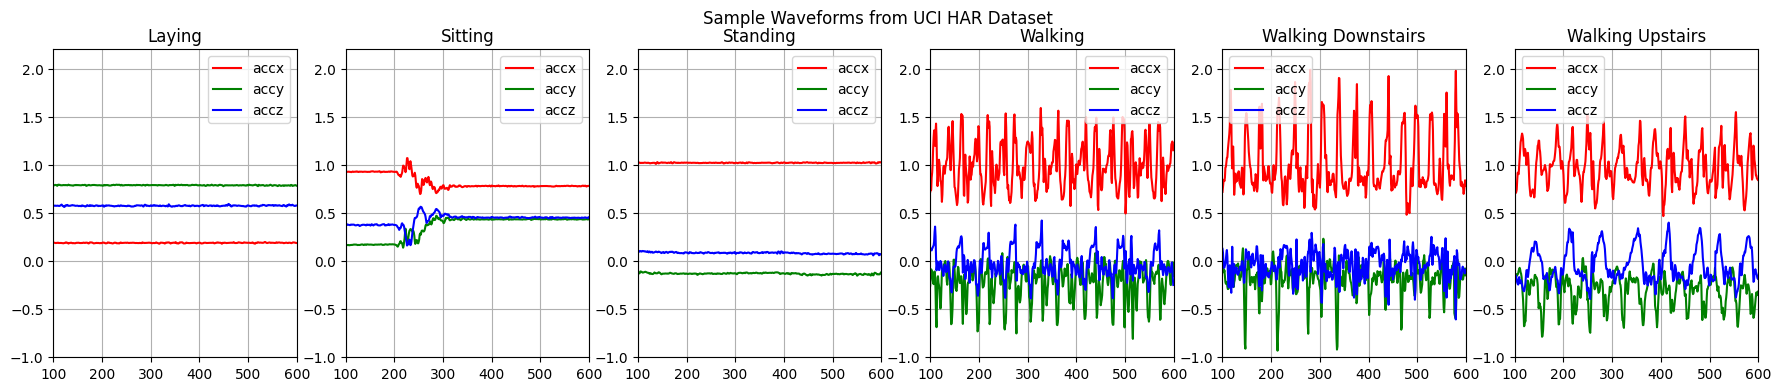

In [182]:
# First Plot: Data from "Datasets/task4_datacollection/raw_dataset/Train"
sample_data1 = get_sample_data(os.path.join("Datasets", 'task4_datacollection', 'raw_dataset', 'Train'), 1)
titles1 = [sample.split('\\')[4].title().replace('_', ' ') for sample in sample_data1]
plot_waveforms(sample_data1, titles1, "Sample Waveforms from Task 4 Dataset", 0)

# Second Plot: Data from "Datasets/Combined/Train"
sample_data2 = get_sample_data(os.path.join("Datasets", 'Combined', 'Train'), 1)
titles2 = [sample.split('\\')[3].title().replace('_', ' ') for sample in sample_data2]
plot_waveforms(sample_data2, titles2, "Sample Waveforms from UCI HAR Dataset", 100)


## 1. Using the pretrained Decision tree to classify recorded activities

We took 2 pretrained Decision trees:
1. The one that is trained on the raw accelerometer data.
2. The one that is trained on the featurised TSFEL data.

We evaluated the accuracy in predicting the 

### Training on UCI HAR raw data, testing on custom data

In [183]:
from MakeDataset import X_train, y_train
from MakeTask4Dataset import X as X_test, y as y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (126, 500, 3)
X_test shape: (72, 500, 3)
y_train shape: (126,)
y_test shape: (72,)
X_train_flat shape: (126, 1500)
X_test_flat shape: (72, 1500)


In [184]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



In [185]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.29      0.17      0.21        12
  WALKING_UPSTAIRS       0.00      0.00      0.00        12
WALKING_DOWNSTAIRS       0.33      0.58      0.42        12
           SITTING       0.07      0.17      0.10        12
          STANDING       1.00      0.17      0.29        12
            LAYING       1.00      1.00      1.00        12

          accuracy                           0.35        72
         macro avg       0.45      0.35      0.34        72
      weighted avg       0.45      0.35      0.34        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.2857, Recall = 0.1667, Accuracy = 0.7917
Class WALKING_UPSTAIRS: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
Class WALKING_DOWNSTAIRS: Precision = 0.3333, Recall = 0.5833, Accuracy = 0.7361
Class SITTING: Precision = 0.0667, Recall = 0.1667, Accuracy = 0.4722
Class STANDING: Precision

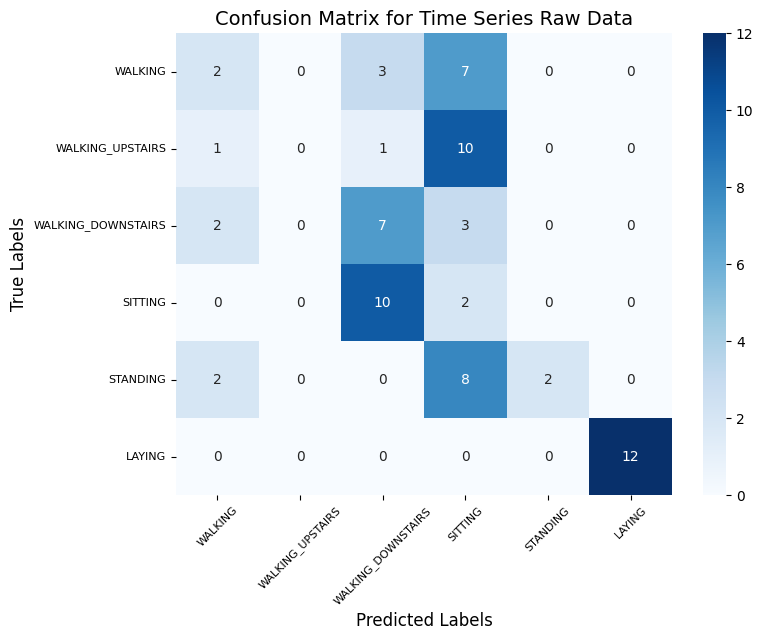

In [186]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()


### Training on all 1173 UCI HAR TSFEL features, testing on custom data

In [187]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

In [188]:

base_dir1 = 'Datasets/TSFEL_3axes_allfeatures'  
base_dir2 = 'Datasets/task4_datacollection/TSFEL_dataset'
X_train, y_train = load_tsfel_dataset(base_dir1, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir2, 'Train')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")



X_train shape: (126, 1, 1173)
y_train shape: (126,)
X_test shape: (48, 1, 1173)
y_test shape: (48,)
X_train_flat shape: (126, 1173)
X_test_flat shape: (48, 1173)
X_train shape: (126, 1, 1173)
X_test shape: (48, 1, 1173)
y_train shape: (126,)
y_test shape: (48,)
X_train_flat shape: (126, 1173)
X_test_flat shape: (48, 1173)


In [189]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         8
  WALKING_UPSTAIRS       0.50      0.62      0.56         8
WALKING_DOWNSTAIRS       0.60      0.38      0.46         8
           SITTING       0.00      0.00      0.00         8
          STANDING       0.40      0.75      0.52         8
            LAYING       0.50      0.12      0.20         8

          accuracy                           0.48        48
         macro avg       0.50      0.48      0.46        48
      weighted avg       0.50      0.48      0.46        48

Precision, Recall, and Accuracy for each

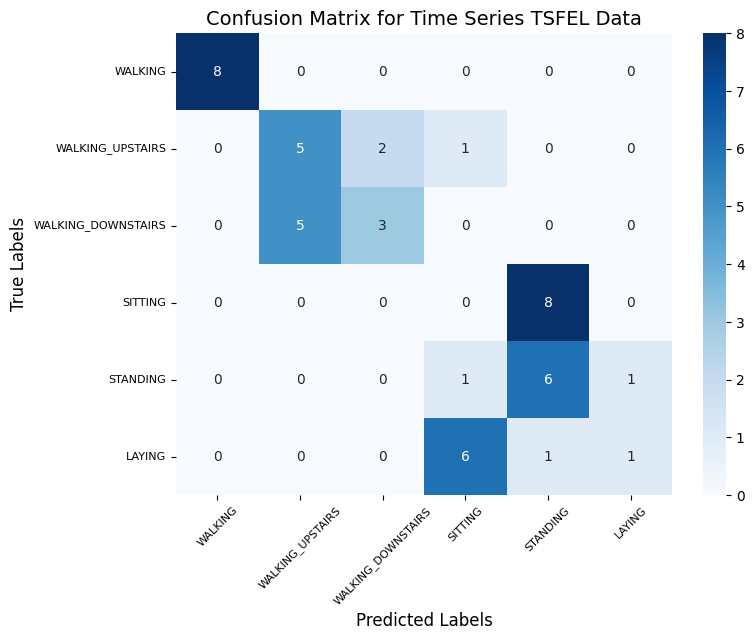

In [190]:

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series TSFEL Data', fontsize=14)

plt.show()

### Training on filtered 60 UCI HAR TSFEL features, testing on custom data

In [191]:

base_dir1 = 'Datasets/TSFEL_3axes_filteredfeatures'  
base_dir2 = 'Datasets/task4_datacollection/TSFEL_filtereddataset'
X_train, y_train = load_tsfel_dataset(base_dir1, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir2, 'Train')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")



X_train shape: (126, 1, 60)
y_train shape: (126,)
X_test shape: (48, 1, 60)
y_test shape: (48,)
X_train_flat shape: (126, 60)
X_test_flat shape: (48, 60)
X_train shape: (126, 1, 60)
X_test shape: (48, 1, 60)
y_train shape: (126,)
y_test shape: (48,)
X_train_flat shape: (126, 60)
X_test_flat shape: (48, 60)


In [192]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         8
  WALKING_UPSTAIRS       0.70      0.88      0.78         8
WALKING_DOWNSTAIRS       1.00      0.62      0.77         8
           SITTING       0.80      1.00      0.89         8
          STANDING       0.64      0.88      0.74         8
            LAYING       0.75      0.38      0.50         8

          accuracy                           0.79        48
         macro avg       0.81      0.79      0.78        48
      weighted avg       0.81      0.79      0.78        48

Precision, Recall, and Accuracy for each

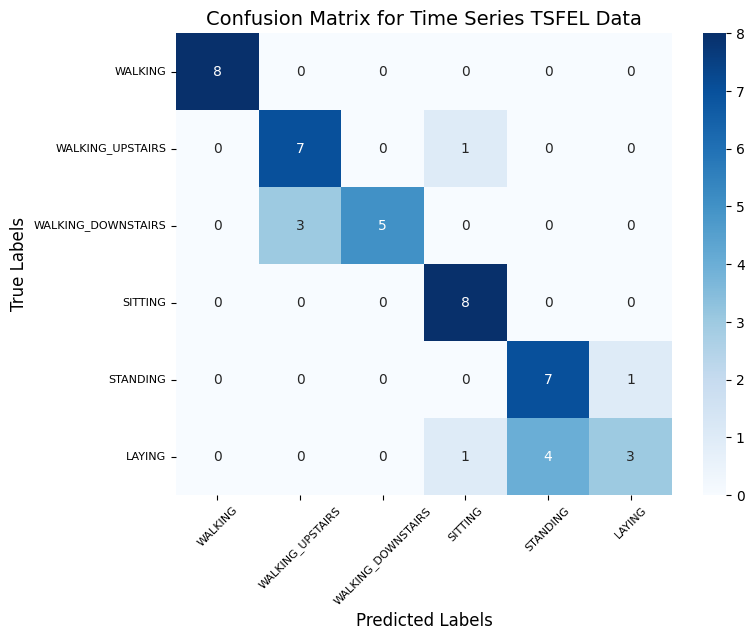

In [193]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series TSFEL Data', fontsize=14)

plt.show()

## 2. Training on Collected data

### In this part first 2 subjects are of the custom dataset, testing on the third subject of custom dataset

In [151]:
from MakeTask4Dataset import X_train, y_train, X_test, y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")


X_train shape: (48, 500, 3)
X_test shape: (24, 500, 3)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 1500)
X_test_flat shape: (24, 1500)


In [152]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.33      0.50      0.40         4
  WALKING_UPSTAIRS       0.50      0.25      0.33         4
WALKING_DOWNSTAIRS       0.75      0.75      0.75         4
           SITTING       0.25      0.25      0.25         4
          STANDING       1.00      1.00      1.00         4
            LAYING       1.00      1.00      1.00         4

          accuracy                           0.62        24
         macro avg       0.64      0.62      0.62        24
      weighted avg       0.64      0.62      0.62        24

Precision, Recall, and Accuracy for each

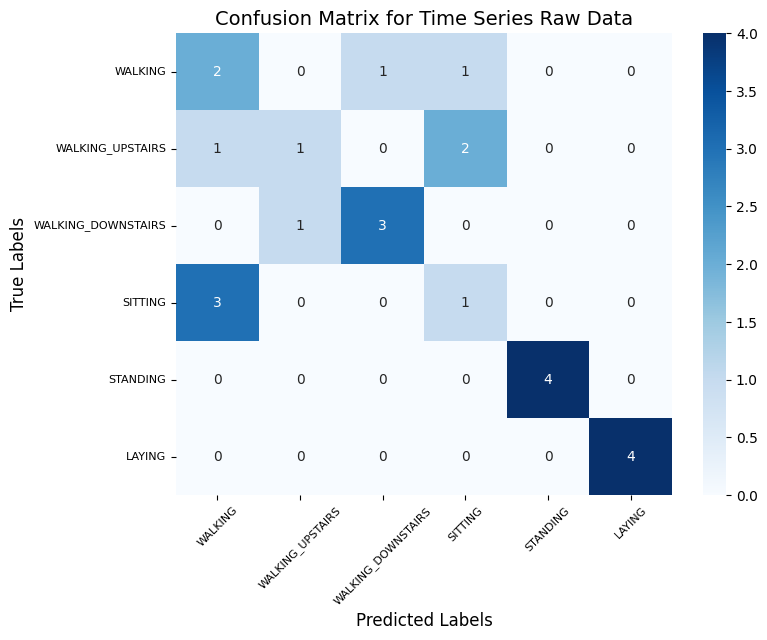

In [153]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()

### Training on all 1173 features of TSFEL data
In this part first 2 subjects of custom dataset, testing on the third subject of custom dataset

In [154]:
base_dir = 'Datasets/task4_datacollection/TSFEL_dataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (48, 1, 1173)
y_train shape: (48,)
X_test shape: (24, 1, 1173)
y_test shape: (24,)
X_train_flat shape: (48, 1173)
X_test_flat shape: (24, 1173)
X_train shape: (48, 1, 1173)
X_test shape: (24, 1, 1173)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 1173)
X_test_flat shape: (24, 1173)


In [155]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         4
  WALKING_UPSTAIRS       1.00      1.00      1.00         4
WALKING_DOWNSTAIRS       1.00      1.00      1.00         4
           SITTING       1.00      0.50      0.67         4
          STANDING       0.00      0.00      0.00         4
            LAYING       0.44      1.00      0.62         4

          accuracy                           0.75        24
         macro avg       0.74      0.75      0.71        24
      weighted avg       0.74      0.75      0.71        24

Precision, Recall, and Accuracy for each

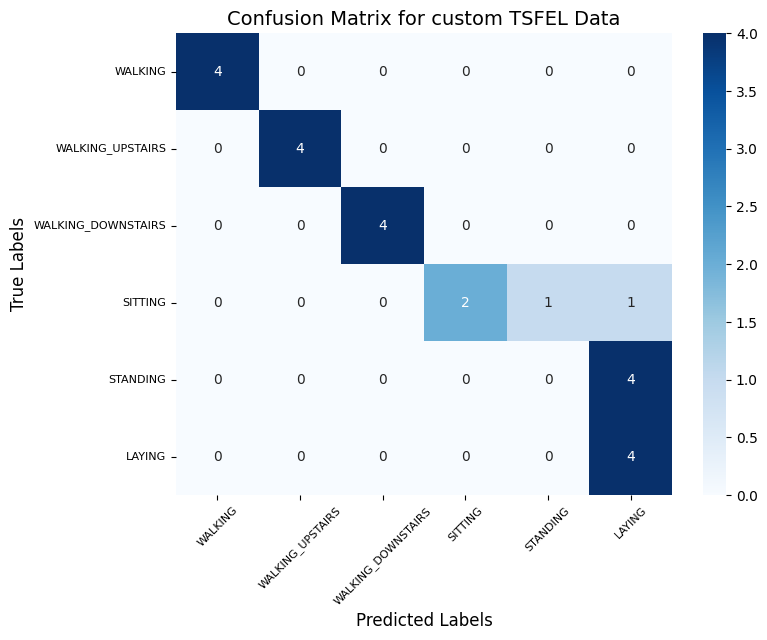

In [156]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for custom TSFEL Data', fontsize=14)

plt.show()

### Training on filtered TSFEL data
In this part first 2 subjects of custom dataset, testing on the third subject of custom dataset

In [157]:
base_dir = 'Datasets/task4_datacollection/TSFEL_filtereddataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (48, 1, 60)
y_train shape: (48,)
X_test shape: (24, 1, 60)
y_test shape: (24,)
X_train_flat shape: (48, 60)
X_test_flat shape: (24, 60)
X_train shape: (48, 1, 60)
X_test shape: (24, 1, 60)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 60)
X_test_flat shape: (24, 60)


In [158]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         4
  WALKING_UPSTAIRS       0.80      1.00      0.89         4
WALKING_DOWNSTAIRS       1.00      0.75      0.86         4
           SITTING       0.75      0.75      0.75         4
          STANDING       0.25      0.25      0.25         4
            LAYING       0.25      0.25      0.25         4

          accuracy                           0.67        24
         macro avg       0.67      0.67      0.67        24
      weighted avg       0.67      0.67      0.67        24

Precision, Recall, and Accuracy for each

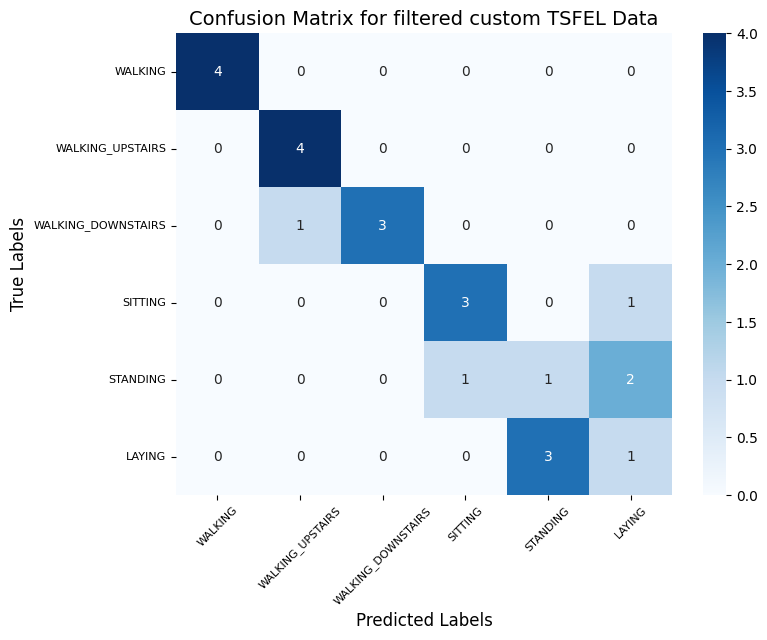

In [159]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for filtered custom TSFEL Data', fontsize=14)

plt.show()

## Cross validation on collected data

### Leave one out cross validation on raw custom data

In [160]:
classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
           4: "SITTING", 5: "STANDING", 6: "LAYING"}

X_flat = X.reshape(X.shape[0], -1)

loo = LeaveOneOut()

y_true_all = []
y_pred_all = []

for train_index, test_index in loo.split(X_flat):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)


In [161]:

print("Classification Report:\n")
print(classification_report(y_true_all, y_pred_all, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_true_all, y_pred_all, average=None)
recall = recall_score(y_true_all, y_pred_all, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true_all == class_label, y_pred_all == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)

print(f"\nOverall Precision (Macro-averaged): {precision_macro:.4f}")
print(f"Overall Recall (Macro-averaged): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

Classification Report:

                    precision    recall  f1-score   support

           WALKING       0.25      0.17      0.20        12
  WALKING_UPSTAIRS       0.15      0.17      0.16        12
WALKING_DOWNSTAIRS       0.00      0.00      0.00        12
           SITTING       0.58      0.92      0.71        12
          STANDING       0.80      1.00      0.89        12
            LAYING       1.00      1.00      1.00        12

          accuracy                           0.54        72
         macro avg       0.46      0.54      0.49        72
      weighted avg       0.46      0.54      0.49        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.2500, Recall = 0.1667, Accuracy = 0.7778
Class WALKING_UPSTAIRS: Precision = 0.1538, Recall = 0.1667, Accuracy = 0.7083
Class WALKING_DOWNSTAIRS: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.7639
Class SITTING: Precision = 0.5789, Recall = 0.9167, Accuracy = 0.8750
Class STANDING: Precision

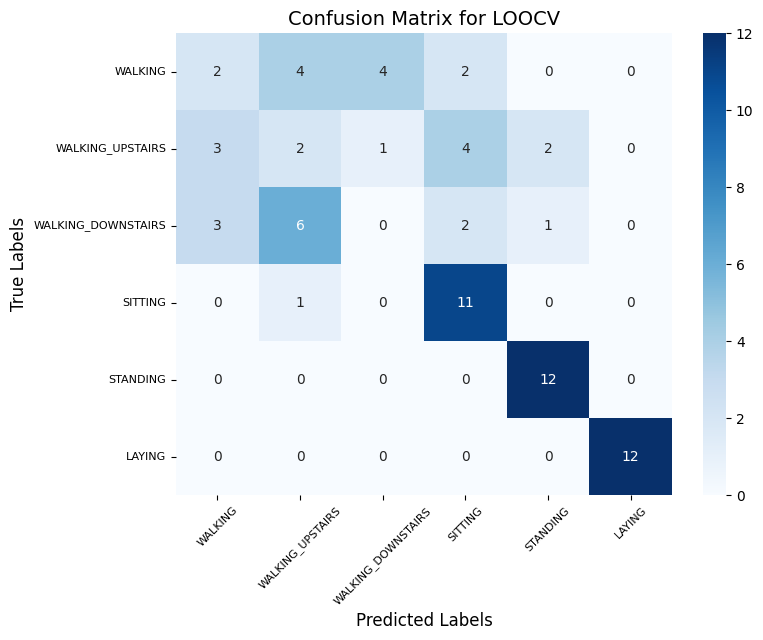

In [162]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for LOOCV', fontsize=14)

plt.show()

### Leave one out cross validation on complete TSFEL featurized custom dataset

In [163]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, precision_score, recall_score, accuracy_score, 
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from MakeTask4Dataset import X, y
base_dir = 'Datasets/task4_datacollection/TSFEL_dataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')
# Concatenate the training and testing data
X = np.concatenate((X_train, X_test), axis=0)  # Concatenate along the first axis (rows)
y = np.concatenate((y_train, y_test), axis=0)  # Concatenate along the first axis (rows)

# Print shapes to verify
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
# Dictionary to map class labels to activity names
classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
           4: "SITTING", 5: "STANDING", 6: "LAYING"}

# Flatten the data
X_flat = X.reshape(X.shape[0], -1)

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Initialize lists to store true labels and predictions
y_true_all = []
y_pred_all = []

# Perform Leave-One-Out Cross-Validation
for train_index, test_index in loo.split(X_flat):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Store the true labels and predictions
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

X shape: (72, 1, 1173)
y shape: (72,)


In [164]:
# Print classification report
print("Classification Report:\n")
print(classification_report(y_true_all, y_pred_all, target_names=[classes[i] for i in sorted(classes.keys())]))

# Calculate precision, recall, and accuracy for each class
precision = precision_score(y_true_all, y_pred_all, average=None)
recall = recall_score(y_true_all, y_pred_all, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true_all == class_label, y_pred_all == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

# Calculate overall precision, recall, and accuracy
precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)

print(f"\nOverall Precision (Macro-averaged): {precision_macro:.4f}")
print(f"Overall Recall (Macro-averaged): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       1.00      0.92      0.96        12
  WALKING_UPSTAIRS       1.00      0.83      0.91        12
WALKING_DOWNSTAIRS       1.00      0.92      0.96        12
           SITTING       1.00      0.92      0.96        12
          STANDING       0.92      1.00      0.96        12
            LAYING       0.75      1.00      0.86        12

          accuracy                           0.93        72
         macro avg       0.95      0.93      0.93        72
      weighted avg       0.95      0.93      0.93        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 0.9167, Accuracy = 0.9722
Class WALKING_UPSTAIRS: Precision = 1.0000, Recall = 0.8333, Accuracy = 0.9861
Class WALKING_DOWNSTAIRS: Precision = 1.0000, Recall = 0.9167, Accuracy = 0.9861
Class SITTING: Precision = 1.0000, Recall = 0.9167, Accuracy = 0.9861
Class STANDING: Precision

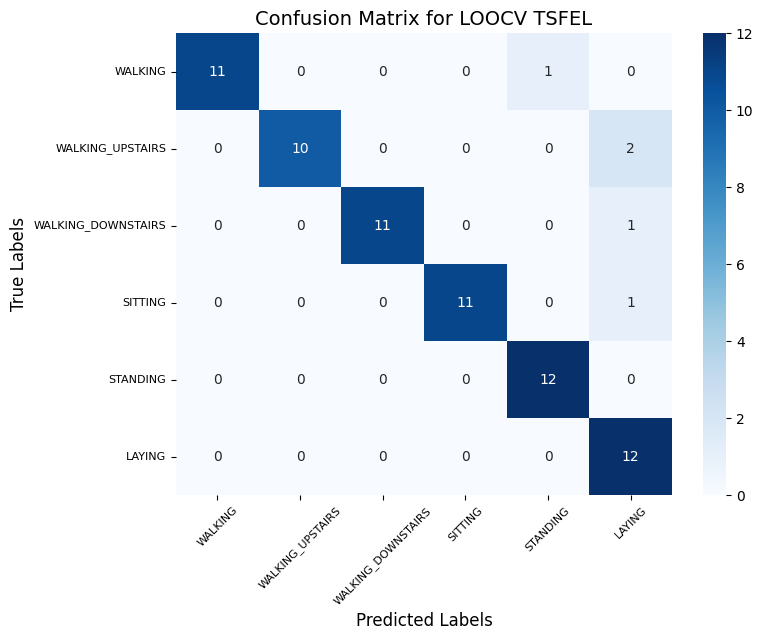

In [165]:

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for LOOCV TSFEL', fontsize=14)

plt.show()

### Leave one out cross validation on filtered TSFEL featurized custom dataset

In [166]:
base_dir = 'Datasets/task4_datacollection/TSFEL_filtereddataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

X = np.concatenate((X_train, X_test), axis=0)  # Concatenate along the first axis (rows)
y = np.concatenate((y_train, y_test), axis=0)  # Concatenate along the first axis (rows)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
           4: "SITTING", 5: "STANDING", 6: "LAYING"}

X_flat = X.reshape(X.shape[0], -1)

loo = LeaveOneOut()

y_true_all = []
y_pred_all = []

for train_index, test_index in loo.split(X_flat):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

X shape: (72, 1, 60)
y shape: (72,)


In [167]:
print("Classification Report:\n")
print(classification_report(y_true_all, y_pred_all, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_true_all, y_pred_all, average=None)
recall = recall_score(y_true_all, y_pred_all, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true_all == class_label, y_pred_all == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)

print(f"\nOverall Precision (Macro-averaged): {precision_macro:.4f}")
print(f"Overall Recall (Macro-averaged): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00        12
  WALKING_UPSTAIRS       0.83      0.83      0.83        12
WALKING_DOWNSTAIRS       0.92      0.92      0.92        12
           SITTING       0.79      0.92      0.85        12
          STANDING       0.91      0.83      0.87        12
            LAYING       0.82      0.75      0.78        12

          accuracy                           0.88        72
         macro avg       0.88      0.88      0.87        72
      weighted avg       0.88      0.88      0.87        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 1.0000, Accuracy = 0.9444
Class WALKING_UPSTAIRS: Precision = 0.8333, Recall = 0.8333, Accuracy = 0.9722
Class WALKING_DOWNSTAIRS: Precision = 0.9167, Recall = 0.9167, Accuracy = 0.9444
Class SITTING: Precision = 0.7857, Recall = 0.9167, Accuracy = 0.9583
Class STANDING: Precision

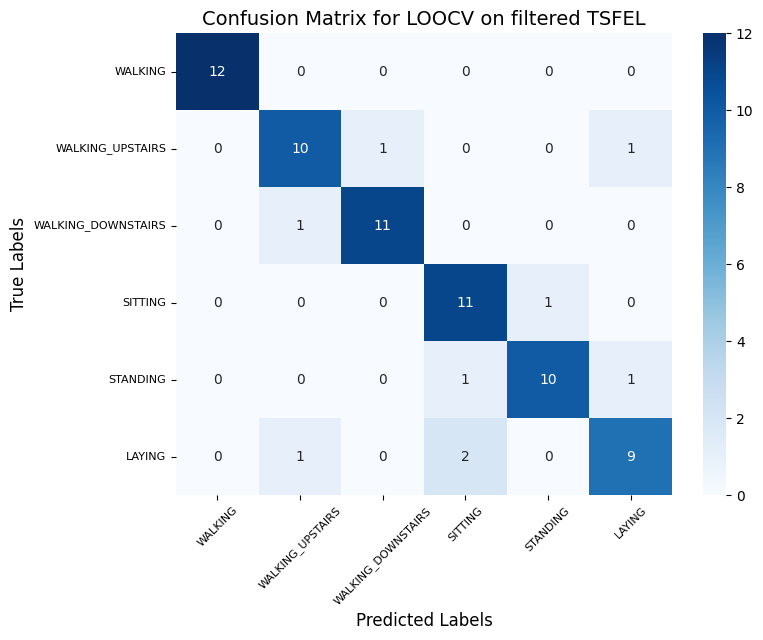

In [168]:

conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for LOOCV on filtered TSFEL', fontsize=14)

plt.show()

In [2]:
class Example:
    def __init__(self, data: Union[pd.DataFrame, None], classification: Union[str, None], modify=False, precision=None):
        self.data = self.modify_data(data, precision) if modify else data
        self.classification = classification
        self.text = self.format_data_to_string(self.data)

    @staticmethod
    def modify_data(data: Union[pd.DataFrame, None], precision=None):
        data = data.round(precision if precision is not None else 0) if data is not None else data
        return data
    
    @staticmethod
    def format_data_to_string(data: Union[pd.DataFrame, None]) -> str:
        if data is not None:
            array = data.to_numpy()
            array_str = np.array2string(array, separator=',', threshold=np.inf, max_line_width=np.inf)
            formatted_str = re.sub(r'[\[\]]', '', array_str).replace(' ', '')
            return formatted_str
        return ''

## Few shot prompting on custom dataset

In this section we run few shot prompting on the custom dataset. We run the following experiments:

1. We use the UCI HAR raw data to provide the examples and query the model on the custom dataset.
2. We use the UCI HAR TSFEL data to provide the examples and query the model on the custom dataset.
3. We use the raw custom data to provide the examples and query the model on the custom dataset.

After running these experiments these are the analysis of the results which we get:

The accuracy of the model when prompted on the UCI HAR raw data and tested on the custom dataset is 4.17%. When we use TSFEL features, we get an accuracy of 49.3%. This is because of the following reasons:

3. Use the Few-Shot prompting method using UCI-HAR dataset to predict the activities that you performed. Ensure that both your examples and test query undergo similar preprocessing. How did the model perform? [1 marks]

The sampling frequency of the original dataset was 50 Hz, but Physics Toolbox Suite forced a frequency of 200 Hz. Also, this frequency was not uniform. We had to apply various data processing techniques to get it close to a 50 Hz time-series. Due to this, we suspect that values may not be entirely accurate. This is why we only got an accuracy of 49.3%. Using TSFEL, we were able to provide featurized data to the model, which boosted its accuracy. This shows that simply using the x, y and z components of acceleration may not be enough. Since the features provided TSFEL are nontrivial functions of the accelerations, we are able to generate more meaningful information to work with. However, because of the differences in the methods of collecting data, the general trend in the features obtained slightly differs from those obtained using UCI HAR. This explains the drop in accuracy when we provide the UCI HAR data featurized by TSFEL as examples versus when we provide our custom data as examples.

4. Use the Few-Shot prompting method using the data you collected to predict the activities that you performed. Adopt proper processing methods as needed. How did the model perform? [1 marks]

When we provide our custom data as examples in the prompt template, we leave one subject for testing. This is because ideally, you should not have data belonging to the same subject in both, the training and the test sets. The general trend of the data we collected is similar and distinguishable enough in both, the training and test examples which we have provided. This explains the higher accuracy of 62.5%.

### UCI HAR raw data as examples

In [3]:
from MakeDataset import X, y

activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
titles = [activity_class.replace('_', ' ').title() for activity_class in activity_classes]
X = [pd.DataFrame(df, columns=['accx', 'accy', 'accz']).iloc[240:260, :].reset_index(drop=True) for df in X]
sampled_indices = list(range(0, 125, 21)) + list(range(1, 125, 21))
uci_examples = []

for sampled_index in sampled_indices:
    uci_examples.append(Example(X[sampled_index], titles[int(y[sampled_index]) - 1], True, 3))

In [4]:
dir = r'.\Datasets\task4_datacollection\raw_dataset'

X_train, y_train, X_test, y_test = [], [], [], []
training_examples = []
testing_examples = []

def load_custom_data(data_type):
    data = []
    labels = []    
    for activity_class in activity_classes:
        activity_folder = os.path.join(dir, data_type, activity_class)        
        for file_name in os.listdir(activity_folder):
            if file_name.endswith('.csv'):
                df = pd.read_csv(os.path.join(activity_folder, file_name))
                df = pd.DataFrame(df, columns=['accx', 'accy', 'accz']).iloc[240:260, :].reset_index(drop=True)
                data.append(df)
                labels.append(activity_class)
    
    return data, labels

X_train, y_train = load_custom_data('Train')
X_test, y_test = load_custom_data('Test')

for df, label in zip(X_train, y_train):
    training_examples.append(Example(df, label.replace('_', ' ').title(), True, 3))

for df, label in zip(X_test, y_test):
    testing_examples.append(Example(df, label.replace('_', ' ').title(), True, 3))

combined_examples = training_examples.copy()
combined_examples.extend(testing_examples)

In [5]:
load_dotenv()
groq_models = {"llama-3.1-8b-instant": "llama-3.1-8b-instant", "llama-3.1-70b-versatile": "llama-3.1-70b-versatile", "llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}

num_api_keys = 12
model_name = "llama-3.1-70b-versatile"

In [6]:
query_str = """You are an expert classifier. You are given some values of the following features of a human, in order:
1. accx: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. accy: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. accz: Mean of the body acceleration signal in the Z-axis (lateral movement).

These values are sampled at a frequency of 50 hz. 

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in uci_examples:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(combined_examples):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + combined_examples[cur_example].text).content.strip()
        print(response)
        print(combined_examples[cur_example].classification)
        print()

        if response == combined_examples[cur_example].classification:
            correct += 1
        total += 1
        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Laying
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking
Sitting

Walking
Sitting

Walking
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking
Standing

Sitting
Standing

Sitting
Standing

Walking
Standing

Walking
Standing

Walking
Standing

Walking
Standing

Walking
Standing

Laying
Walking

Laying
Walking

Laying
Walking

Standing
Walking

Laying
Walking

Laying
Walking

Laying
Walking

Laying
Walking

Laying
Walking Downstairs

Laying
Walking Downstairs

Standing
Walking Downstairs

Laying
Walking Downstairs

Walking
Walking Downstairs

Laying
Walking Downstairs

Walking Downstairs
Walking Downstairs

Walking
Walking Downstairs

Walking Downstairs
Walking Upstairs

Walking Downstairs
Walking Upstairs

Standing
Walking Upstairs

Walking Upstairs
Walki

### Collected data as examples

In [ ]:
query_str = """You are an expert classifier. You are given some values of the following features of a human, in order:
1. accx: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. accy: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. accz: Mean of the body acceleration signal in the Z-axis (lateral movement).

These values are sampled at a frequency of 50 hz. 

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in training_examples:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(testing_examples):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + testing_examples[cur_example].text).content.strip()
        print(response)
        print(testing_examples[cur_example].classification)
        print()

        if response == testing_examples[cur_example].classification:
            correct += 1
        total += 1
        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

Laying
Laying

Laying
Laying

Laying
Laying

Laying
Laying

Sitting
Sitting

Sitting
Sitting

Sitting
Sitting

Sitting
Sitting

Standing
Standing

Standing
Standing

Standing
Standing

Standing
Standing

Walking Downstairs
Walking

Walking Downstairs
Walking

Walking Downstairs
Walking

Walking Downstairs
Walking

Walking
Walking Downstairs

Walking
Walking Downstairs

Walking
Walking Downstairs

Walking Upstairs
Walking Downstairs

Walking Upstairs
Walking Upstairs

Walking Upstairs
Walking Upstairs

Walking Downstairs
Walking Upstairs

Walking Upstairs
Walking Upstairs

Accuracy: 62.50%


### UCI-HAR TSFEL features as examples

In [19]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def load_csv_files(directory, label, add_timestamp=True, add_total_acc=True, trim_data=True, n_files=None):
    df_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            df['subject'] = filename.replace('.csv', '')
            # 50 samples per second
            # 1 sample takes 1/50 seconds
            if add_timestamp:
                df['timestamp'] = (df.index + 1) / 50
            if add_total_acc:
                df['total_acc'] = df['accx'] ** 2 + df['accy'] ** 2 + df['accz'] ** 2
            if trim_data:
                df_list.append(df.iloc[100:600, :])
            else:
                df_list.append(df)

    if n_files is not None:
         df_list = df_list[:n_files]

    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['y'] = label
    return combined_df

def get_tsfel_features(tsfel_features_path, n_sample=None):   
    data = pd.DataFrame()
    for label, activity_class in enumerate(activity_classes):
        folder_path = os.path.join(tsfel_features_path, activity_class)
        dfs = load_csv_files(folder_path, label, False, False, False, n_sample)
        data = pd.concat([data, dfs], axis=0, ignore_index=True)
    return data

def get_tsfel_feat_uci_har(examples=2):
	all_data = get_tsfel_features(r'Datasets\TSFEL_3axes_filteredfeatures\Train', examples).sample(frac=1)
	X_train = all_data.drop(columns=['y', 'subject'])
	X_train = [X_train.iloc[i, :20] for i in range(X_train.shape[0])]
	y_train = list(all_data['y'].to_numpy())
	y_train = [activity_classes[i] for i in y_train]
 
	all_data = get_tsfel_features(r'Datasets\TSFEL_3axes_filteredfeatures\Test', examples).sample(frac=1)
	X_test = all_data.drop(columns=['y', 'subject'])
	X_test = [X_test.iloc[i, :20] for i in range(X_test.shape[0])]
	y_test = list(all_data['y'].to_numpy())
	y_test = [activity_classes[int(i)] for i in y_test]
 
	return X_train, y_train, X_test, y_test

def get_tsfel_feat_custom():
	all_data = get_tsfel_features(r'Datasets\task4_datacollection\TSFEL_filtereddataset\Train').sample(frac=1)
	X_train = all_data.drop(columns=['y', 'subject'])
	X_train = [X_train.iloc[i, :20] for i in range(X_train.shape[0])]
	y_train = list(all_data['y'].to_numpy())
	y_train = [activity_classes[i] for i in y_train]
 
	all_data = get_tsfel_features(r'Datasets\task4_datacollection\TSFEL_filtereddataset\Test').sample(frac=1)
	X_test = all_data.drop(columns=['y', 'subject'])
	X_test = [X_test.iloc[i, :20] for i in range(X_test.shape[0])]
	y_test = list(all_data['y'].to_numpy())
	y_test = [activity_classes[int(i)] for i in y_test]
 
	return X_train, y_train, X_test, y_test

uci_X_train, uci_y_train, uci_X_test, uci_y_test = get_tsfel_feat_uci_har(examples=4)
own_X_train, own_y_train, own_X_test, own_y_test = get_tsfel_feat_custom()

In [20]:
uci_X_train = [pd.DataFrame(df) for df in uci_X_train]
own_X_train = [pd.DataFrame(df) for df in own_X_train]
own_X_test = [pd.DataFrame(df) for df in own_X_test]

In [21]:
uci_examples = []
own_examples_combined = []
own_examples_train = []
own_examples_test = []

for df, label in zip(uci_X_train, uci_y_train):
    uci_examples.append(Example(df.T, label.replace('_', ' ').title(), True, 3))

for df, label in zip(own_X_train, own_y_train):
    own_examples_train.append(Example(df.T, label.replace('_', ' ').title(), True, 3))

for df, label in zip(own_X_test, own_y_test):
    own_examples_test.append(Example(df.T, label.replace('_', ' ').title(), True, 3))

own_examples_combined = own_examples_train.copy()
own_examples_combined.extend(own_examples_test)

In [22]:
query_str = """You are an expert classifier. You are given some values of the following features of a human, in order:
accx_Absolute energy, accx_Area under the curve, accx_Average power, accx_ECDF Percentile Count_0, accx_ECDF Percentile Count_1, accx_FFT mean coefficient_89, accx_LPCC_8, accx_Lempel-Ziv complexity, accx_MFCC_1, accx_MFCC_10, accx_MFCC_11, accx_MFCC_3, accx_MFCC_5, accx_MFCC_8, accx_Maximum fractal length, accx_Mean absolute diff, accx_Median frequency, accx_Signal distance, accx_Skewness, accx_Spectral decrease

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in uci_examples:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(own_examples_combined):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + own_examples_combined[cur_example].text).content.strip()
        print(response)
        print(own_examples_combined[cur_example].classification)
        print()

        if response == own_examples_combined[cur_example].classification:
            correct += 1 
        total += 1
        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

Walking
Walking Upstairs

Walking
Walking Downstairs

Sitting
Standing

Sitting
Sitting

Walking Downstairs
Walking Downstairs

Sitting
Standing

Walking
Walking

Standing
Sitting

Laying
Laying

Walking Upstairs
Walking

Walking
Walking

Laying
Laying

Laying
Laying

Standing
Walking Upstairs

Laying
Laying

Walking
Walking Upstairs

Sitting
Standing

Sitting
Sitting

Standing
Walking Upstairs

Walking Upstairs
Walking

Walking
Walking Downstairs

Walking
Walking

Walking Downstairs
Walking Downstairs

Laying
Laying

Standing
Walking Upstairs

Sitting
Sitting

Sitting
Standing

Walking
Walking Upstairs

Sitting
Standing

Walking
Walking

Sitting
Sitting

Sitting
Standing

Standing
Standing

Sitting
Sitting

Sitting
Sitting

Laying
Laying

Laying
Laying

Walking Downstairs
Walking

Walking
Walking

Walking
Walking Downstairs

Walking
Walking Upstairs

Walking Downstairs
Walking Downstairs

Walking Downstairs
Walking Downstairs

Walking
Walking Downstairs

Walking
Walking Upstairs

Sitt

## Collected data TSFEL features as examples

In [ ]:
query_str = """You are an expert classifier. You are given some values of the following features of a human, in order:
accx_Absolute energy, accx_Area under the curve, accx_Average power, accx_ECDF Percentile Count_0, accx_ECDF Percentile Count_1, accx_FFT mean coefficient_89, accx_LPCC_8, accx_Lempel-Ziv complexity, accx_MFCC_1, accx_MFCC_10, accx_MFCC_11, accx_MFCC_3, accx_MFCC_5, accx_MFCC_8, accx_Maximum fractal length, accx_Mean absolute diff, accx_Median frequency, accx_Signal distance, accx_Skewness, accx_Spectral decrease

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in own_examples_train:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(own_examples_test):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + own_examples_test[cur_example].text).content.strip()
        print(response)
        print(own_examples_test[cur_example].classification)
        print()

        if response == own_examples_test[cur_example].classification:
            correct += 1
        total += 1
        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')